# Machine learning enabled detection of soil moisture stress on the physiology of photosynthesis using remotely sensed surface reflectance

#### This notebook uses:
- data from the satellite products MOD09GA, MODOCGA, MOD11A1 and MYD11A1
- data from the FLUXNET sites: classid, temp, APAR
- data from the fLUE analysis (flue and is_flue_drought)
- data if the site is homogeneous
- data about the homogeneous sites

This data is largely publicly available as described in 01_ImportData but is also available on Euler. Depending on the source, the data should be imported (01_ImportData.ipynb), it should pass a quality control (02_QualityControl.ipynb) and if wished interpolated (03_MissingData.ipynb). 

#### This notebook contains:
- an analysis of the input variables (correlations of the variables and the NDI with fLUE)
- a clustering of the sites based on the NDI/flue correlations
- a modelling of fLUE and the agricultural drought prediction
- the analysis and both the analysis of the data regarding the correlation of different bands and fLUE as well as the 

In [1]:
# enables the use of R code in a cell after writing "%%R making it an cell for R code 
%load_ext rpy2.ipython   

Check for dependencies: Install all packages and dependencies in R, and system dependencies (especially if using a Linux OS).
rbeni and ingestr is not available in CRAN and must be loaded from github repositories:
- https://github.com/stineb/rbeni
- https://github.com/computationales/ingestr

<span style="color:red">**To do:**</span> After installing everything, download those two folders and adapt your local path to those folders. Also, set the working directory. Furthermore, the code needs a folder called data containing a file which is the output from 02_MissingData or can be found on EULER under data/flue_modis. Cell 5 must be adapted (name dependencies).

In [2]:
%%R 
# path_rbeni = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/rbeni-master/"
# path_ingestr = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/ingestr-master/"
path_rbeni = "/home/zhud/wsl/MasterThesis/rsvi/data/rbeni-master/"
path_ingestr = "/home/zhud/wsl/MasterThesis/rsvi/data/ingestr-master/"

In [3]:
%%capture
%%R 
# set working directory
setwd("/home/zhud/wsl/MasterThesis/rsvi")
# the R libraries and R files used:
source("wrap_ml.R")
# source("wrap_ml2.R")          # does not improve the model
library(dplyr)                  # not available packages can be installed over R / R studio
library(lubridate)              # https://rpy2.github.io/doc/v2.9.x/html/robjects_rpackages.html
library(readr)
library(ggplot2)
library(tidyr)                  
library(caret)
library(tidyverse)              
library(yardstick)     
library(recipes)
library(caret)
library(binaryLogic)
library(patchwork)
library(LSD)
library(ggthemes)
library(RColorBrewer)
library(devtools)
devtools::load_all(path_rbeni)
library(rbeni)                                       
devtools::load_all(path_ingestr)
library(ingestr)
library(stringr)
library(doParallel)

# Preprocessed data (subset for homogeneous sites, filtered by quality, merged with flue data and towres data)
load("./data/obs_eval_NT.Rdata")    # for site and date contains information about: fapar <dbl>, ccov_cru_int <dbl>, temp_fluxnet2015 <dbl>, prec_fluxnet2015 <dbl>,
                                    #                                              vpd_fluxnet2015 <dbl>, ppfd_fluxnet2015 <dbl>, gpp_obs <dbl>,
                                    #                                              transp_obs <dbl>, soilm_obs_mean <dbl>, temp <dbl>, GPP_NT_VUT_REF <dbl>,
                                    #                                              GPP_DT_VUT_REF <dbl>, year <dbl>

Failed to create bus connection: No such file or directory


In [4]:
# python libraries
# NDI
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# cluster
# import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Analysis

### Site selection and complement data with air temperature and vegetation type
Subset homogenous sites. Selection of sites is based on whether sites could be allocated to clusters in Stocker et al. (2018) and based on the selection by Manuela Balzarolo (see `site_selection_rsvi.Rmd`).
Get fLUE Stocker et al., 2018 publicly available data here: https://zenodo.org/record/1158524#.W_bNMZNKjOQ

<span style="color:red">**To do:**</span> Chose which data should be analyzed:

In [5]:
%%R
# read in satellite Data
# conditions to fill missing data
method_fill = "interpolation" # "None" # "interpolation"
method_gap = "seasonal_mean" # "remain_NA" # "seasonal_mean"
maxgap = 2
n_maxgap=9

# read in satellite data of homogeneous sites that have their missing data filled
# information about flue is already included in MissingData_complete
path_filled_data <- stringr::str_glue("./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1_MOD11A1_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}.csv")
ddf <- readr::read_csv(path_filled_data) 

Rows: 105990 Columns: 47
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): site, cluster
dbl  (43): flue, YY, MM, DD, lst_aqua_NA, lst_terra_NA, b01_NA, b02_NA, b03_...
lgl   (1): is_flue_drought
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
# check if library(dplyr) is loaded, else do it again...
ddf_nn <- ddf %>%
        left_join(siteinfo_fluxnet2015 %>% dplyr::select(site=sitename, classid), by = "site") %>%
        left_join(dplyr::rename(obs_eval_NT$ddf, site=sitename), by=c("site", "date")) %>%
        mutate (APAR = ppfd_fluxnet2015 * fapar) %>%
        dplyr::filter(!is.na(flue)) %>%
        # dplyr::select(date, site, is_flue_drought, flue, all_of(dovars), APAR, temp, classid) %>%
        mutate(classid=factor(classid), is_flue_drought = factor(is_flue_drought)) %>%
        drop_na()

In [7]:
%%R
# reduce data depending on what to analyse
ddf_paula <- ddf %>% 
    select(date, site, flue, is_flue_drought, ndvi, evi, NIRv, cci, pri)
ddf_paula_bands <- ddf %>% 
    select(date, site, flue, is_flue_drought,b01, b02, b03,b11, b12)
ddf_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14)
ddf_lst_aqua <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14, b15, b16) 
ddf_lst_aqua_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14) 
ddf_lst_terra_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_terra, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14) 
ddf_lst_aqua_indices <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, ndvi, evi, NIRv, cci, pri)
ddf_lst_aqua_bands_for_indices <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b02, b01, b03, b11, b12) # bands used to calculate indices
ddf_lst_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, lst_terra, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14)
ddf_difference_lst_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14)
ddf_lst_aqua_selected <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14) 

#### Tidy data

Complement info using the meta info of FLUXNET sites provided through rsofun.
Includes temperature, APAR, and select only 5 vegetation classes. Clean database, no NA

In [8]:
%%R
add_meta_info_and_clean <- function(ddf){
    # Vegetation classes
    cv <- c("ENF","DBF","GRA","EBF","SAV")

    ddf_nn <- ddf %>%
        left_join(siteinfo_fluxnet2015 %>% dplyr::select(site=sitename, classid), by = "site") %>%
        left_join(dplyr::rename(obs_eval_NT$ddf, site=sitename), by=c("site", "date")) %>%
        mutate (APAR = ppfd_fluxnet2015 * fapar) %>%
        dplyr::filter(!is.na(flue)) %>%
        # dplyr::select(date, site, is_flue_drought, flue, all_of(dovars), APAR, temp, classid) %>%
        mutate(classid=factor(classid), is_flue_drought = factor(is_flue_drought)) %>% 
        drop_na()

    # Subset ONLY 5 classes (cv)
    ddf_nn$classid[ddf_nn$classid=="WSA"] <- "SAV"
    ddf_sub <- ddf_nn %>%
        dplyr::filter(classid %in% cv) %>% 
        droplevels()
    # deparse(substitute(variableName)) becomes part of the Rdata name
    filename <- str_glue('./data/{deparse(substitute(ddf))}_sub.Rdata')
    save(ddf_sub, file = filename)
}

In [9]:
%%R -o ddf_lst_b01_to_b14
# comparison between the different land surface temperatures
ddf_difference_lst_b01_to_b14$d_temp <- ddf_lst_b01_to_b14$lst_aqua - ddf_lst_b01_to_b14$lst_terra

<AxesSubplot:xlabel='lst_aqua', ylabel='lst_terra'>

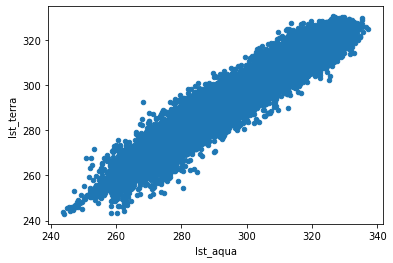

In [10]:
ddf_lst_b01_to_b14.plot.scatter(x='lst_aqua', y='lst_terra')

Predictors and data ready to train (ddf_sub)


In [11]:
%%R
paula                      <- c("ndvi", "evi", "cci", "pri", "NIRv", "APAR",  "temp", "classid")
lst_aqua_indices           <- c("ndvi", "evi", "cci", "pri", "NIRv", "APAR", "lst_aqua",  "classid")
temp_bands_for_indices     <- c("b01", "b02", "b03", "b11", "b12", "classid", 'temp')
lst_mod09a1                <- c( "lst_aqua", "lst_terra", "temp", "b01", "b02", "b03", "b04", "b05", "b06", "b07", "classid")
lst_aqua                   <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15", "b16", 
                                "lst_aqua", "classid")
# Band 1 to 14, and T_air
b01_to_b14                 <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "temp", "classid")
# Band 1 to 14, classid
b01_to_b14_class             <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "classid")
# Band 1 to 14, and T_aqua
lst_aqua_b01_to_b14        <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_aqua", "classid")
# Band 1 to 14,Tair and T_aqua
lst_aqua_Tair_b01_to_b14        <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_aqua","temp", "classid")
# Band 1 to 14,Tair and T_terra
lst_terra_Tair_b01_to_b14 <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_terra","temp", "classid")
# Band 1 to 14, and T_terra
lst_terra_b01_to_b14        <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_terra", "classid")
# Band 1 to 14, T_air,T_aqua, and T_terra)
lst_b01_to_b14             <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_aqua", "lst_terra", "temp", "classid")
# Band 1 to 14, T_air,T_aqua, and T_terra, no classid)
lst_b01_to_b14_noClass      <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_aqua", "lst_terra", "temp")
# Band 1 to 14, T_air and d(T_aqua-T_terra)
difference_lst_b01_to_b14  <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "d_temp", "temp", "classid")
# selected bands due to similar data and to minimise the risk of overfitting
lst_aqua_selected          <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b10", "b12", "b14", 
                                "lst_aqua", "classid")
# select bands from rsvis
paula_bands  <- c("b01", "b02", "b03", "b11", "b12", "classid", "temp")
# adapt what to analyse

add_meta_info_and_clean(ddf_lst_b01_to_b14) # select database to analyze
load("./data/ddf_lst_b01_to_b14_sub.Rdata") # load data 
pred_var <- lst_b01_to_b14                  # define predictor variables of the model
name <- "lst_b01_to_b14"                    # define the name of the predictor variables used as part of the model name
model <- "nnet"                             # define the algorithm used to train the model
training_method <- "myLGOCV"                # define the training method
sites <- ddf_sub$site %>% unique()

In [12]:
%%R
path_variables <- str_glue("./flue_modis/SmallGaps_{maxgap}_{method_fill}_LargeGaps_{method_gap}_ifSeasonalMean_ndays_{n_maxgap}.csv")
write_csv(ddf_sub[c("site", lst_b01_to_b14, "flue", "is_flue_drought")], path =path_variables)

# NDI

In [13]:
%%R -o ddf_sub
#summary(df_test_inner) # flue: Median : 0.97142, 3rd Qu.: 1.00693, Max.   : 1.84895 
summary(ddf_sub)

      date                site                flue         is_flue_drought
 Min.   :2000-05-13   Length:35566       Min.   :-0.2471   FALSE:22540    
 1st Qu.:2006-07-26   Class :character   1st Qu.: 0.7441   TRUE :13026    
 Median :2009-06-03   Mode  :character   Median : 0.9704                  
 Mean   :2009-02-19                      Mean   : 0.8761                  
 3rd Qu.:2011-12-28                      3rd Qu.: 1.0085                  
 Max.   :2014-12-30                      Max.   : 1.9244                  
    lst_aqua       lst_terra          b01               b02          
 Min.   :261.8   Min.   :259.8   Min.   :-1989.4   Min.   :  -55.75  
 1st Qu.:290.8   1st Qu.:289.9   1st Qu.:  675.8   1st Qu.: 2387.75  
 Median :297.5   Median :296.3   Median : 1472.1   Median : 3165.50  
 Mean   :299.9   Mean   :297.9   Mean   : 2610.2   Mean   : 3868.04  
 3rd Qu.:309.8   3rd Qu.:306.3   3rd Qu.: 4002.2   3rd Qu.: 4864.88  
 Max.   :337.1   Max.   :330.5   Max.   :14232.5   Max.

In [14]:
# rough estimate of wavelength of bands in [nm] 
# b01: 650 b02: 860 b03: 470 b04: 550 b05: 1240 b06: 1640 b07: 2125
# b08: 410 b09: 445 b10: 488 b11: 530 b12: 550 b13: 667 b14: 678
df_bands = ddf_sub[[
    # sorted after their respective bandwidth
       'site', 'flue', 'classid',
       'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07',
       'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14'
]]

In [15]:
df_bands.to_pickle("./df_bands.pkl")

In [16]:
df = pd.read_pickle("./df_bands.pkl")

In [17]:
df_wavelength = df[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
]]

In [18]:
# sorting of bands for the NDI plots 
bands_wavelength = [ '413', '445', '469', '488', '531','551',  '555',  
                     '645', '667', '678', '859','l 1240', 'l 1640', 'l 2130'  ]
df_wavelength = df_wavelength.set_axis([ '413', '445', '469', '488', '531','551', '555',  
                                         '645', '667', '678', '859','l 1240', 'l 1640', 'l 2130'  ], axis=1, inplace=False)
bands_range = [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ]
df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)

In [19]:
df_sorted = df[[  'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07',
               'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14'  ]]

In [20]:
bands_sorted = [ 'b01', 'b02','b03', 'b04', 'b05', 'b06', 'b07',
                 'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14' ]

In [21]:
# calculate a list with band1 band2 and
# band-lable
data = []
for band_i in bands_sorted:     # band1 
    for band_j in bands_sorted: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_sorted[band_i] - df_sorted[band_j]) / (df_sorted[band_i] + df_sorted[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_sorted = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])
# bandwidth
data = []
for band_i in bands_range:     # band1 
    for band_j in bands_range: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_range[band_i] - df_range[band_j]) / (df_range[band_i] + df_range[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_range = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])
# wavelength
data = []
for band_i in bands_wavelength:     # band1 
    for band_j in bands_wavelength: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_wavelength[band_i] - df_wavelength[band_j]) / (df_wavelength[band_i] + df_wavelength[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_wavelength = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])


In [22]:
def ndi_combinations(df, bands, criteria):
    '''
     df               dataframe        col_x - col_y
     bands            list of names of the columns in the dataframe
     criteria         a column with the same length as elements in the dataframe
     returns a list   with combinations of columns of the dataframe and the result of correlating (col_x - col_y)/(col_x - col_y) with the criteria
    '''
    data = []
    for band_i in bands:     # band1 
        for band_j in bands: # band2
            band1 = f'{band_i}'
            band2 = f'{band_j}'
            ndi_uncorrelated = (df[band_i] - df[band_j]) / (df[band_i] + df[band_j]) 
            ndi = criteria.corr(ndi_uncorrelated)
            data.append([band1, band2, ndi])
    df_ndi = pd.DataFrame(data, columns=["band1", "band2", "ndi"])
    ndi = df_ndi.pivot("band1", "band2", "ndi") # sorts the entries --> change to wavelength [nm]
    return ndi

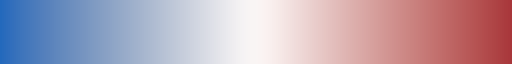

In [23]:
sns.color_palette("vlag", as_cmap=True)

<AxesSubplot:xlabel='band2', ylabel='band1'>

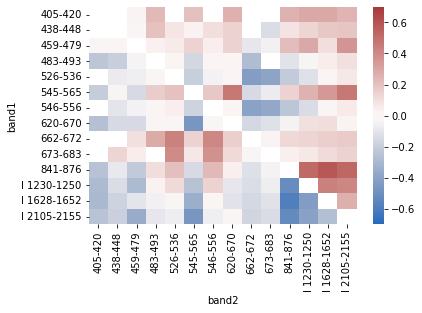

In [24]:
sns.heatmap(ndi_combinations(df_range, bands_range, df['flue']), cmap="vlag", vmin=-0.7, vmax=0.7)

<AxesSubplot:xlabel='band2', ylabel='band1'>

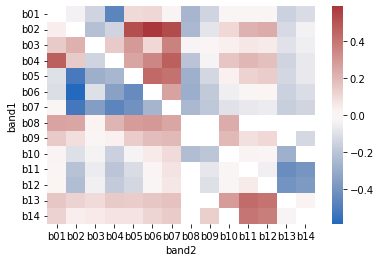

In [25]:
sns.heatmap(ndi_combinations(df_sorted, bands_sorted, df['flue']), cmap="vlag")

In [26]:
method = "None"
maxgap = "interp2"

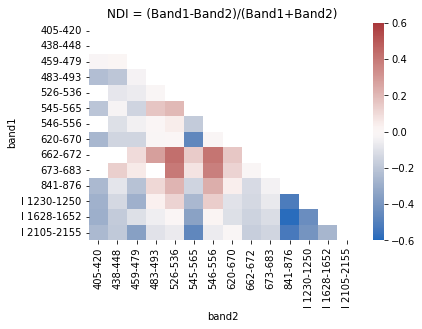

In [27]:
# create matrix that can be used as mask to only display the lower part of the sns plot
# the number of bands is here hard-coded and should be adapted if that ever changes (14)
corr_mask = np.ones((14,14))
matrix = np.triu(corr_mask)
# plot NDI for all sites / data available

plt.figure()
plt.title('NDI = (Band1-Band2)/(Band1+Band2)')
sns.heatmap(ndi_combinations(df_range, bands_range, df['flue']), cmap="vlag", mask=matrix,vmin = -0.6, vmax = 0.6)

plt.savefig(f'results/{method}/NDI_total.png', bbox_inches="tight")

/tmp/ipykernel_21239/1584034112.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


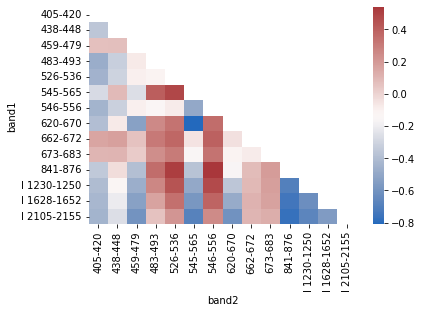

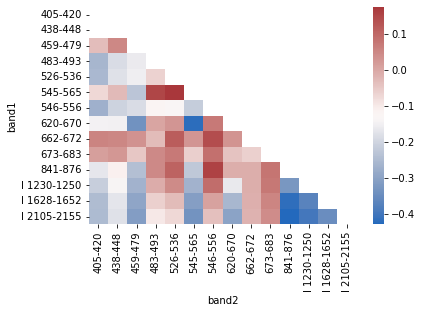

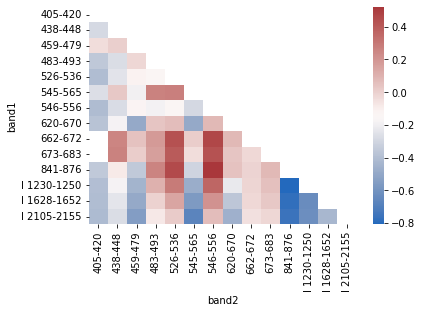

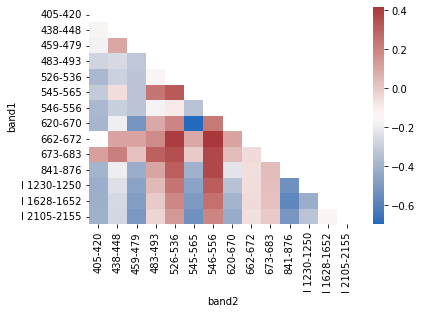

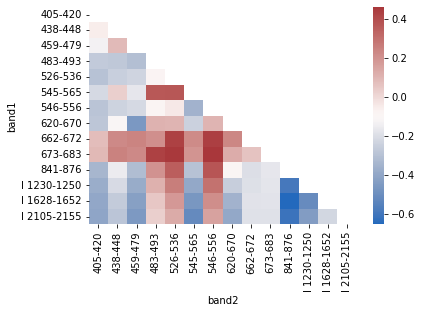

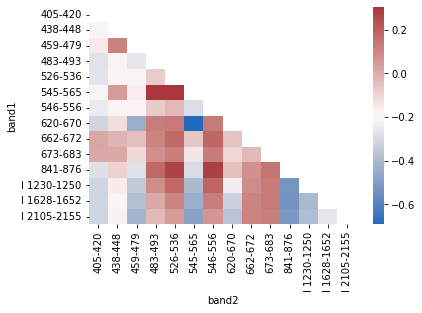

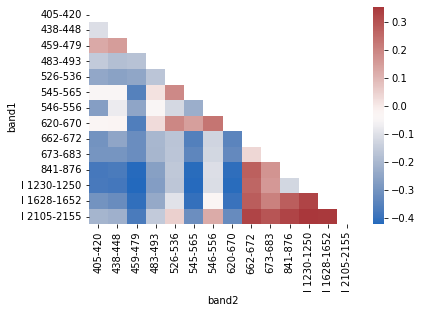

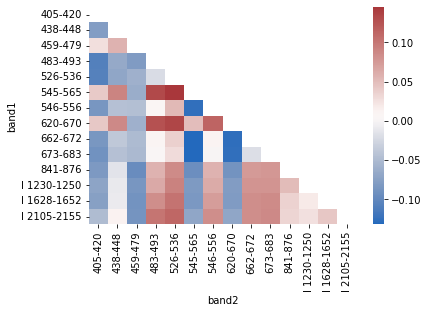

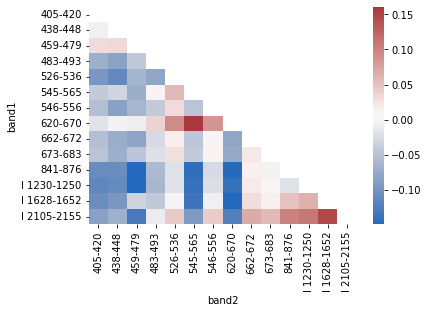

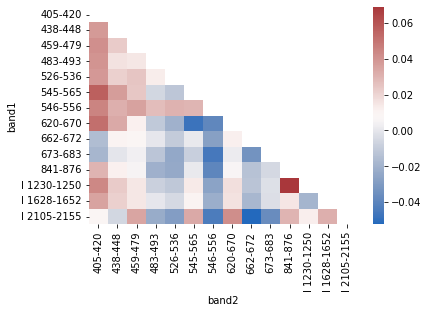

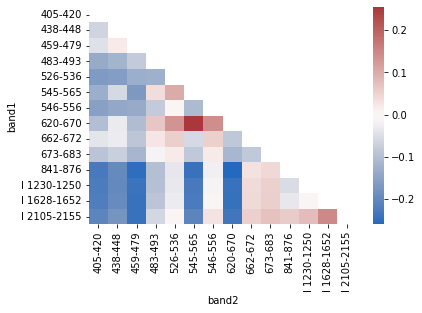

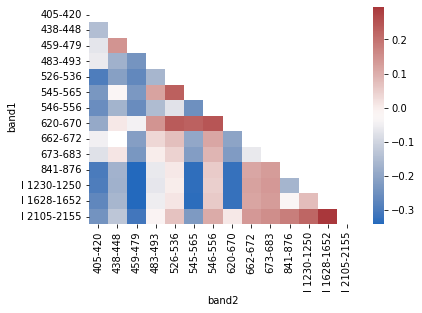

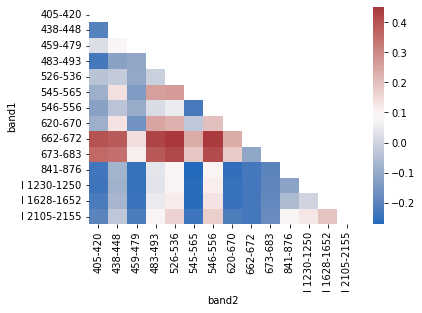

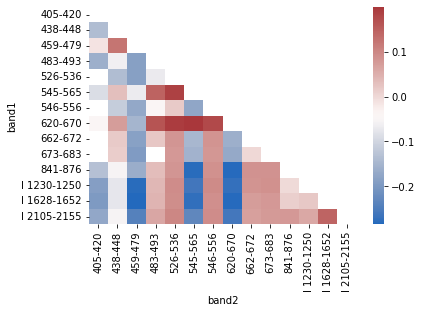

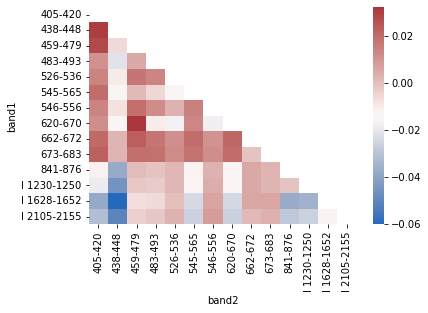

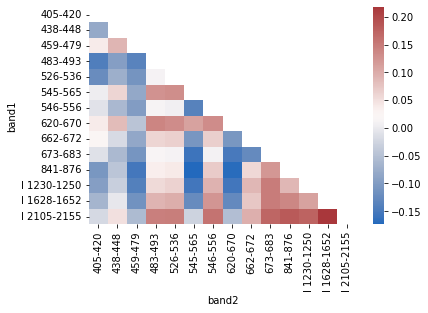

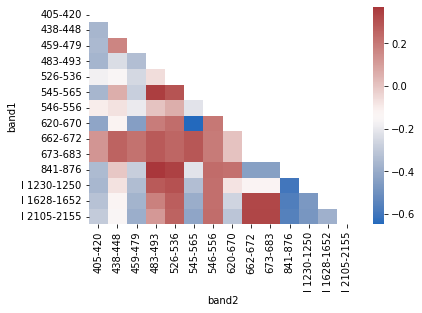

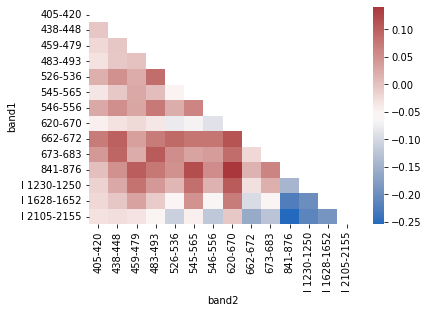

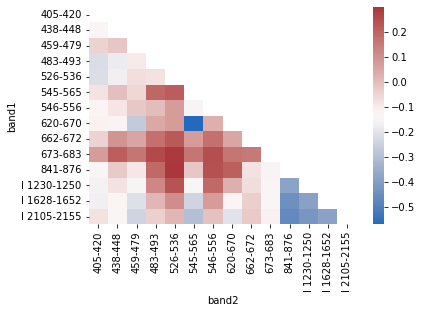

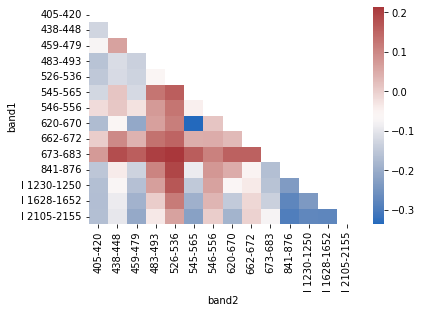

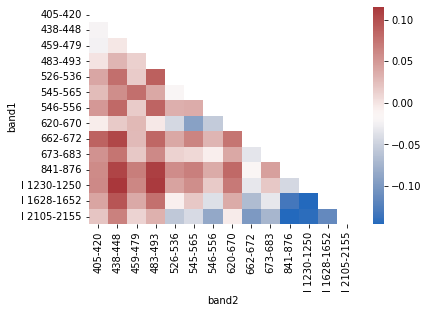

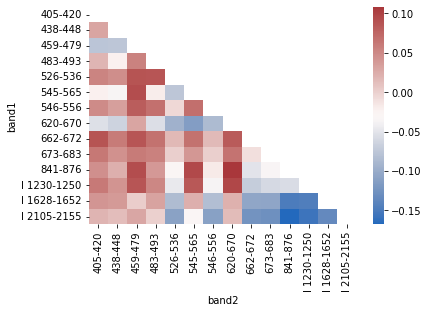

In [28]:
sites = pd.unique(df[['site']].values.ravel()) # for several columns: .values.ravel()
# create matrix that can be used as mask to only display the lower part of the sns plot
# the number of bands is here hard-coded and should be adapted if that ever changes (14)
for s in sites:
    df_s = df[df['site'] == s]
    df_wavelength = df_s[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
    ]]
    df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)
    plt.figure()
    sns.heatmap(ndi_combinations(df_range, bands_range, df_s['flue']), cmap="vlag", mask=matrix)
    plt.savefig(f'results/{method}/{s}_NDI.png', bbox_inches="tight")


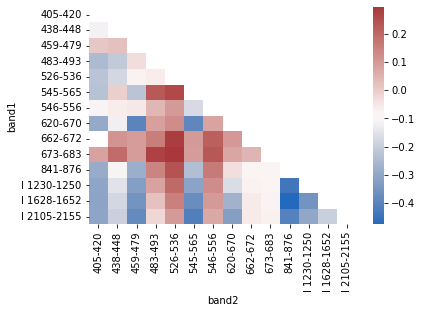

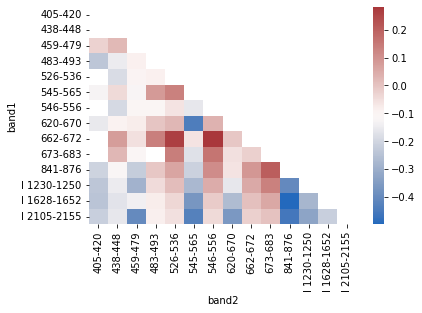

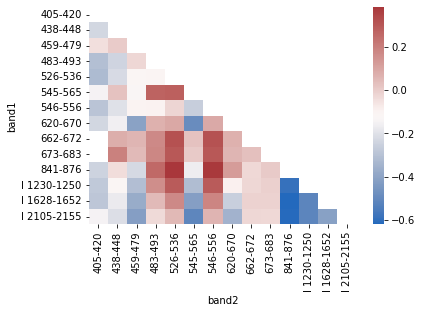

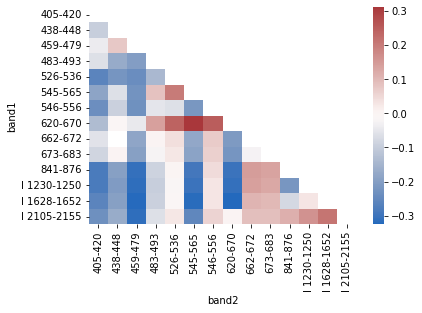

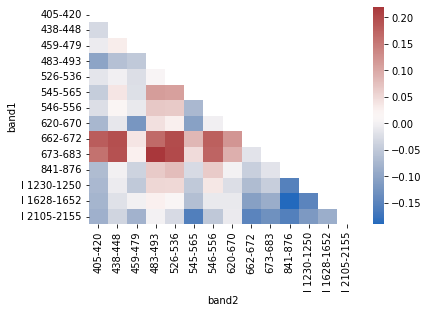

In [29]:
landCoverTypes = pd.unique(df[['classid']].values.ravel()) # for several columns: .values.ravel()
# create matrix that can be used as mask to only display the lower part of the sns plot
# the number of bands is here hard-coded and should be adapted if that ever changes (14)
for s in landCoverTypes:
    df_s = df[df['classid'] == s]
    df_wavelength = df_s[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
    ]]
    df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)
    plt.figure()
    sns.heatmap(ndi_combinations(df_range, bands_range, df_s['flue']), cmap="vlag", mask=matrix)
    plt.savefig(f'results/{method}/{s}_NDI.png', bbox_inches="tight")


# clustering the sites dependend on the NDI/fLUE correlation
Three popular categories of clustering algorithms:

#### Partitional clustering
   
Partitional clustering divides data objects into k nonoverlapping groups. 

Examples of algorithms: k-means or k-medoids (both would be non-deterministic)

| PRO | CON |
| --- | --- |
| Well suited for clusters with spherical shape | Not well suited for clusters with complex shapes and different sizes |
| Scalable | Clusters should not be of different densities |



#### Hierarchical clustering
Hierarchical clustering builds a dendrogram by either a bottom-up or top-down approach.

Examples of algorithms: 
 - Agglomerative clustering (bottom-up approach - most similar points are merged until they are combined into one cluster) 
 - Divisive clustering (top-down approach - divides the least similar clusters with each step until a single point remains)

| PRO | CON |
| --- | --- |
| Reveal the finer details about the relationships between data objects | Computationally expensive |
| Provide an interpretable dendrogram | Sensitive to noise and outliers |



#### Density-based clus|tering
Density-based clustering determines clusters based on the density of data points (low density region are cut-offs)

Examples of algorithms: 
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN) 
- Ordering Points To Identify the Clustering Structure (OPTICS)

| PRO | CON |
| --- | --- |
| excel at identifying clusters of nonspherical shapes |  Not well suited for clustering in high-dimensional spaces |
| Resistant to outliers | Clusters shouldn't have varying densities |


Source: https://realpython.com/k-means-clustering-python/ 

In [30]:
def ndi_list(df, bands, criteria):
    '''
     df               dataframe containing of columns containing numeric values
     bands            list of names of the columns in the dataframe (stings)
     criteria         a column with the same length as elements in the dataframe (numeric values)
     returns a list   with the result of correlating (col_x - col_y)/(col_x - col_y) with the criteria for each band combinations
    '''
    data = []
    for band_i in bands:     # band1 
        for band_j in bands: # band2
            band1 = f'{band_i}'
            band2 = f'{band_j}'
            ndi_uncorrelated = (df[band_i] - df[band_j]) / (df[band_i] + df[band_j]) 
            ndi = criteria.corr(ndi_uncorrelated)
            data.append(ndi)
    return data


In [31]:
# save values of each site as a table with the column name being the site name
sites_ndi = pd.DataFrame()
ndi_sites=[]
for s in sites:
    
    df_s = df[df['site'] == s]
    df_wavelength = df_s[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
    ]]
    df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)
  
    ndi_sites.append(ndi_list(df_range, bands_range, df_s['flue']))
ndi_sites_df = pd.DataFrame(ndi_sites, index = sites)
  

In [32]:
# fill NaN with 0
ndi_sites_df = ndi_sites_df.fillna(0)

In [33]:
# mean of 0 and standard deviation of 1
scaler = StandardScaler()
scaled_ndi_sites = scaler.fit_transform(ndi_sites_df)

In [34]:
scaled_ndi_sites[:5]

array([[ 0.        ,  2.14052877, -1.06813209,  2.27849131,  1.93279457,
         1.98006466,  1.33878161,  1.66351543, -1.09636787, -0.66000821,
         1.16004012,  1.36362353,  1.54815767,  1.76644363, -2.14052877,
         0.        , -0.2014207 ,  1.87695767,  1.62059727,  1.92422503,
        -1.33161861,  0.39709746, -0.7894112 , -0.23055568, -0.42862707,
         0.2699853 ,  0.8395343 ,  1.33679284,  1.06813209,  0.2014207 ,
         0.        , -0.42608544, -0.20986851, -0.08294007,  1.0807284 ,
         1.61866839, -0.42258828, -0.25306542,  1.28452294,  1.45724245,
         1.64572893,  1.89190371, -2.27849131, -1.87695767,  0.42608544,
         0.        ,  0.74474313,  1.26829673, -1.95826807, -2.03823617,
        -1.6065741 , -0.82653258, -1.93668406, -1.97023825, -1.77517321,
        -0.79737702, -1.93279457, -1.62059727,  0.20986851, -0.74474313,
         0.        ,  1.04117401, -2.19950013, -2.0684276 , -1.33002159,
        -1.03440405, -2.15469099, -2.38384252, -2.4

In [35]:
kmeans = KMeans(
    init="random",  # initialization technique
    n_clusters=4,   # number of clusters
    n_init=10,      # number of initializations
    max_iter=300,   # lowest SSE
    random_state=42 # number of maximum iterations / initialization
    )

In [36]:
kmeans.fit(scaled_ndi_sites)

KMeans(init='random', n_clusters=4, random_state=42)

In [37]:
# lowest SSE value
kmeans.inertia_

1511.5400016811645

In [38]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 0.        , -0.87022309, -0.46364567, -0.97535354, -0.92684855,
        -0.92936193, -0.98001719, -0.92022555,  0.05601306,  0.18321306,
        -1.09406576, -1.12261253, -1.13376088, -1.06837436,  0.87022309,
         0.        ,  0.70972099, -1.03817463, -1.03674206, -0.87995582,
        -0.06278662, -0.60426073,  0.3748404 ,  0.45471926, -0.72141113,
        -0.93079872, -1.0380442 , -1.03236037,  0.46364567, -0.70972099,
         0.        , -0.88161174, -1.01267662, -0.94950468, -1.01866232,
        -1.01328978,  0.05024288,  0.01967214, -1.04696908, -1.10907162,
        -1.15181715, -1.10674169,  0.97535354,  1.03817463,  0.88161174,
         0.        , -1.01321699, -0.80675311,  0.86606759,  0.65607366,
         0.46493175,  0.52982538,  0.3285727 ,  0.10133194, -0.18143902,
        -0.32974851,  0.92684855,  1.03674206,  1.01267662,  1.01321699,
         0.        , -0.45369228,  1.04112736,  0.86120289,  0.70189301,
         0.72055491,  0.66389093,  0.61839943,  0.5

In [39]:
# The number of iterations required to converge
kmeans.n_iter_

5

In [40]:
a = kmeans.labels_#[:5]
mapping = {0:'blue', 3:'yellow', 1:'green', 2:'red'}
a = [mapping[i] for i in a]

c = pd.DataFrame({"site": sites, "NDI_cluster": a})
df = pd.merge(df, c, on=['site'])

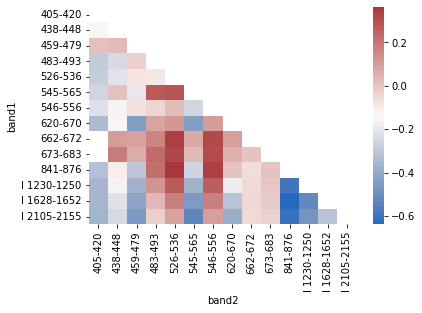

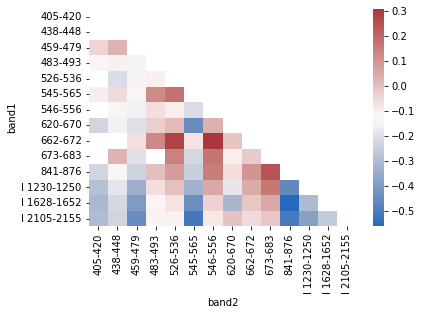

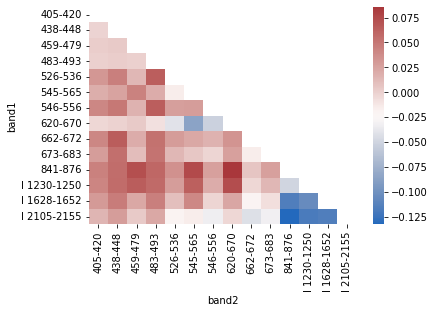

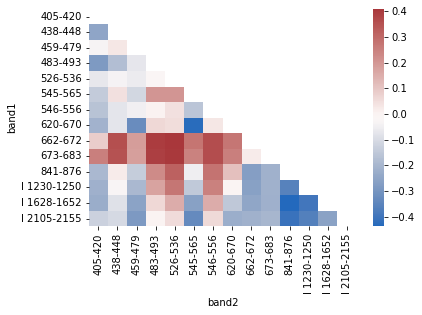

In [41]:
ndi_c = pd.unique(df[['NDI_cluster']].values.ravel()) # for several columns: .values.ravel()
# create matrix that can be used as mask to only display the lower part of the sns plot
# the number of bands is here hard-coded and should be adapted if that ever changes (14)
for s in ndi_c:
    df_s = df[df['NDI_cluster'] == s]
    df_wavelength = df_s[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
    ]]
    df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)
    plt.figure()
    sns.heatmap(ndi_combinations(df_range, bands_range, df_s['flue']), cmap="vlag", mask=matrix)
    plt.savefig(f'results/{method}/{s}_NDI.png', bbox_inches="tight")

In [42]:
# number of clusters: ellbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_ndi_sites)
    sse.append(kmeans.inertia_)

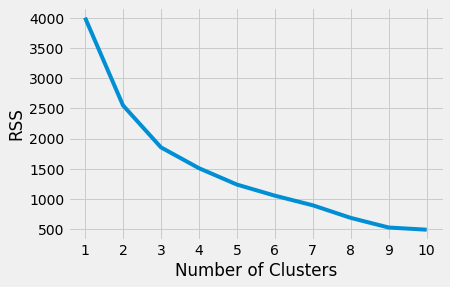

In [43]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("RSS")
plt.show()

In [44]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )
kl.elbow

3

In [45]:
# number of clusters: silhouette coefficient (how far is the point from the cluster)
silhouette_coefficients = []
for k in range(2, 11): # min 2 cluster
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_ndi_sites)
    score = silhouette_score(scaled_ndi_sites, kmeans.labels_)
    silhouette_coefficients.append(score)

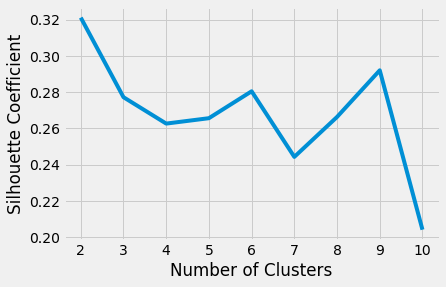

In [46]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()
# here 3 is the max and thus the best choice

# MODEL
### Drought classification

Predictions of drought or non-drought days.

#### Single split (global model)

Must be split by site.

TODO: I looked again at the instructions from the machine learning class. There it was recomended to have a training data and testing set contianing about 80-60% of the data for training (chapter 3.2). Is that because of the relatively small number of sites and because of the grouping it is split up like that? But with less testing there are less robust results. 

In [47]:
%%R 
set.seed(1982)
cat("There are ",length(sites),"sites and thus nsites_train is", floor(0.8*length(sites)))
nsites_train <- floor(0.8*length(sites))
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))
n_sites = nsites_train

There are  22 sites and thus nsites_train is 17

In [48]:
%%R
sites_train

 [1] "NL-Loo" "US-UMd" "DE-Tha" "IT-SRo" "AU-Ade" "US-SRG" "SD-Dem" "AU-Dry"
 [9] "US-MMS" "AU-Stp" "RU-Fyo" "IT-Ro1" "US-UMB" "FR-LBr" "AU-ASM" "AU-Wom"
[17] "US-SRM"


Train model on a single training set and evaluate on the single testing set from the initial split


In [49]:
import os
if not os.path.exists("results"):
    os.makedirs("results")

In [50]:
%%R
# Train model on a single training set and evaluate on the single testing set from the initial split
filepath  <- str_glue('./results/modl_is_flue_drought_nnet_GLOBAL_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{name}_{n_sites}.Rdata')
filepath

./results/modl_is_flue_drought_nnet_GLOBAL_interpolation_seasonal_mean_maxgap_2_9_lst_b01_to_b14_17.Rdata
FALSE


In [51]:
%%R
# Train model on a single training set and evaluate on the single testing set from the initial split
filn <- str_glue('./results/modl_is_flue_drought_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_GLOBAL_{name}_{n_sites}.Rdata')
if (!file.exists(filn)){
  modl <- wrap_ml( df = df_train,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  model,
                   train_method = training_method,
                   predictors = pred_var,
                   tune = FALSE,
                   inner = FALSE,
                   classification = TRUE, 
                   cores = 30
                  )
  ## save model object
  save(modl, file = filn)

} else {
  load(filn)
}

df_test$pred <- predict(modl, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)


 Accuracy     Kappa 
0.7692012 0.5189669 


In [52]:
%%R
df_test$pred <- predict(modl, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)


 Accuracy     Kappa 
0.7692012 0.5189669 


#### Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [53]:
%%R 
filn <- str_glue('./results/modl_is_flue_drought_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_INNER_{name}_{n_sites}.Rdata')
if (!file.exists(filn)){
  modl <- wrap_ml( df = ddf_sub,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  model,
                   train_method = training_method,
                   predictors = pred_var,
                   tune = FALSE,
                   inner = TRUE,
                   classification = TRUE, 
                   cores = 30
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl, file = filn)
} else {
  load(filn)
}

Get evaluation results across left-out sites from inner loop.

R[write to console]: Saving 6.67 x 6.67 in image



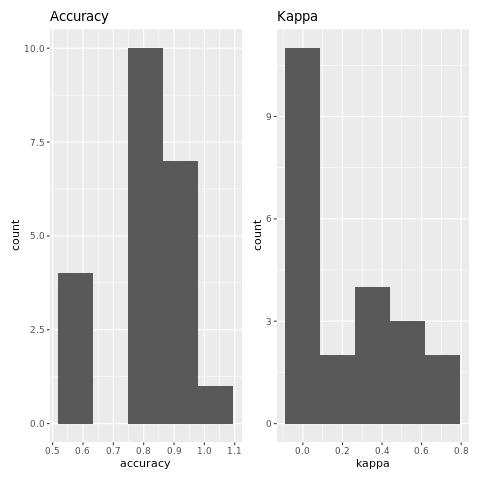

In [54]:
%%R
# pdf(str_glue('./results/modl_is_flue_drought_{model}_{training_method}_INNER_{name}.pdf'))
df_inner <- purrr::map(modl, "results") %>% 
  purrr::map_dbl("accuracy") %>% 
  stack() %>% 
  dplyr::select(site = ind, accuracy = values) %>% 
  left_join(
    purrr::map(modl, "results") %>% 
      purrr::map_dbl("kappa") %>% 
      stack() %>% 
      dplyr::select(site = ind, kappa = values),
    by = "site"
  )

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(kappa_mean = mean(kappa), accuracy_mean = mean(accuracy),
            kappa_median = median(kappa), accuracy_median = median(accuracy),
            kappa_sd = sd(kappa), accuracy_sd = sd(accuracy)) %>% 
  knitr::kable()
# why so little bins? was 5
gg1 <- df_inner %>% 
  ggplot(aes(x = kappa, y = ..count..)) +
  geom_histogram(bins = 5) +                       
  labs(title = "Kappa")

gg2 <- df_inner %>% 
  ggplot(aes(x = accuracy, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "Accuracy")

library(patchwork)
# pdf(str_glue('./results/modl_is_flue_drought_{model}_{training_method}_INNER_{name}.pdf'))
gg2 + gg1
ggsave(str_glue('./results/modl_is_flue_drought_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_INNER_{name}_{n_sites}.pdf'))
gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!

In [55]:
%%R
df_test_inner <- purrr::map_dfr(modl, "df_test")
confusionMatrix( data = df_test_inner$pred,
                 reference = df_test_inner$is_flue_drought, 
                 positive = "TRUE"
                 )

Confusion Matrix and Statistics

          Reference
Prediction FALSE  TRUE
     FALSE 19929  4018
     TRUE   2611  9008
                                          
               Accuracy : 0.8136          
                 95% CI : (0.8095, 0.8176)
    No Information Rate : 0.6338          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5891          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6915          
            Specificity : 0.8842          
         Pos Pred Value : 0.7753          
         Neg Pred Value : 0.8322          
             Prevalence : 0.3662          
         Detection Rate : 0.2533          
   Detection Prevalence : 0.3267          
      Balanced Accuracy : 0.7879          
                                          
       'Positive' Class : TRUE            
                  

### Drought magnitude

Predictions of drought magnitude.

Single split (global model)

Must be split by site.

In [56]:
%%R
set.seed(1982)
cat("There are ",length(sites),"sites and thus nsites_train is",length(sites)-2)
nsites_train <- floor(0.8*length(sites))
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))

There are  22 sites and thus nsites_train is 20

In [57]:
%%R
sites_train

 [1] "NL-Loo" "US-UMd" "DE-Tha" "IT-SRo" "AU-Ade" "US-SRG" "SD-Dem" "AU-Dry"
 [9] "US-MMS" "AU-Stp" "RU-Fyo" "IT-Ro1" "US-UMB" "FR-LBr" "AU-ASM" "AU-Wom"
[17] "US-SRM"


Train model on a single training set and evaluate on the single testing set from the initial split


In [58]:
%%R 
filn <- str_glue('./results/modl_flue_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_GLOBAL_{name}_{n_sites}.Rdata')
if (!file.exists(filn)){
  modl <- wrap_ml( df = df_train,
                   nam_target = "flue",
                   nam_group = "site",
                   method = model,
                   train_method = training_method,
                   predictors = pred_var,
                   tune = TRUE,
                   inner = FALSE,
                   classification = FALSE, 
                   cores = 30
                  )
  ## save model object
  save(modl, file = filn)
} else {
  load(filn)
}

## Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [59]:
%%R 
filn <- str_glue('./results/modl_flue_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_INNER_{name}_{n_sites}.Rdata')
if (!file.exists(filn)){
  modl <- wrap_ml( df = ddf_sub,
                   nam_target = "flue",
                   nam_group = "site",
                   method =  model,
                   train_method = "training_method",
                   predictors = pred_var,
                   tune = FALSE,
                   inner = TRUE,
                   classification = FALSE, 
                   cores = 30
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl, file = filn)
} else {
  load(filn)
}

[1] "training model with leave-site-out: AU-Ade ..."


Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directory
Failed to create bus connection: No such file or directo

[1] "training model with leave-site-out: AU-ASM ..."
[1] "training model with leave-site-out: AU-DaP ..."
[1] "training model with leave-site-out: AU-DaS ..."
[1] "training model with leave-site-out: AU-Dry ..."
[1] "training model with leave-site-out: AU-Stp ..."
[1] "training model with leave-site-out: AU-Wom ..."
[1] "training model with leave-site-out: DE-Obe ..."
[1] "training model with leave-site-out: DE-Tha ..."
[1] "training model with leave-site-out: FI-Hyy ..."
[1] "training model with leave-site-out: FR-LBr ..."
[1] "training model with leave-site-out: IT-Cpz ..."
[1] "training model with leave-site-out: IT-Ro1 ..."
[1] "training model with leave-site-out: IT-SRo ..."
[1] "training model with leave-site-out: NL-Loo ..."
[1] "training model with leave-site-out: RU-Fyo ..."
[1] "training model with leave-site-out: SD-Dem ..."
[1] "training model with leave-site-out: US-MMS ..."
[1] "training model with leave-site-out: US-SRG ..."
[1] "training model with leave-site-out: US-SR

Get evaluation results across left-out sites from inner loop.


R[write to console]: Saving 6.67 x 6.67 in image



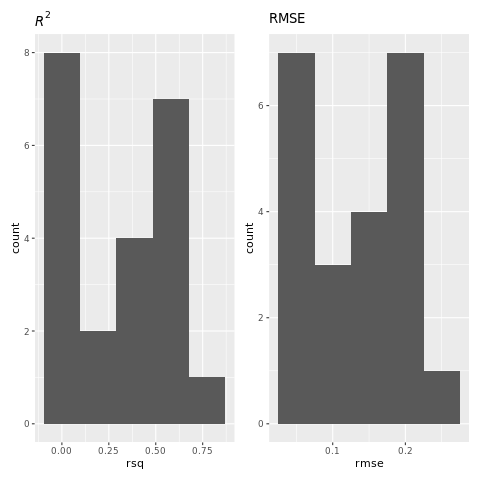

In [60]:
%%R
df_inner <- purrr::map_dfr(modl, "results") %>% 
  pivot_wider(names_from = .metric, values_from = .estimate) %>% 
  dplyr::select(-.estimator)

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(rmse_mean = mean(rmse), rsq_mean = mean(rsq),
            rmse_median = median(rmse), rsq_median = median(rsq),
            rmse_sd = sd(rmse), rsq_sd = sd(rsq)) %>% 
  knitr::kable()

gg1 <- df_inner %>% 
  ggplot(aes(x = rmse, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "RMSE")

gg2 <- df_inner %>% 
  ggplot(aes(x = rsq, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = expression(italic(R)^2))

gg2 + gg1
ggsave(str_glue('./results/modl_flue_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_{model}_{training_method}_INNER_{name}_{n_sites}.pdf'))
gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!


R[write to console]: `geom_smooth()` using formula 'y ~ x'



$df_metrics
# A tibble: 12 × 3
   .metric  .estimator   .estimate
   <chr>    <chr>            <dbl>
 1 rmse     standard       0.149  
 2 rsq      standard       0.582  
 3 mae      standard       0.0990 
 4 n        standard   35566      
 5 slope    standard       0.911  
 6 mean_obs standard       0.876  
 7 prmse    standard       0.170  
 8 pmae     standard       0.113  
 9 bias     standard      -0.00252
10 pbias    standard       0.0493 
11 cor      standard       0.763  
12 cor_test standard       0      

$gg


R[write to console]: `geom_smooth()` using formula 'y ~ x'




$linmod

Call:
lm(formula = obs ~ mod, data = df)

Coefficients:
(Intercept)          mod  
    0.08063      0.91059  


$results
# A tibble: 1 × 6
    rsq  rmse    mae     bias slope     n
  <dbl> <dbl>  <dbl>    <dbl> <dbl> <dbl>
1 0.582 0.149 0.0990 -0.00252 0.911 35566



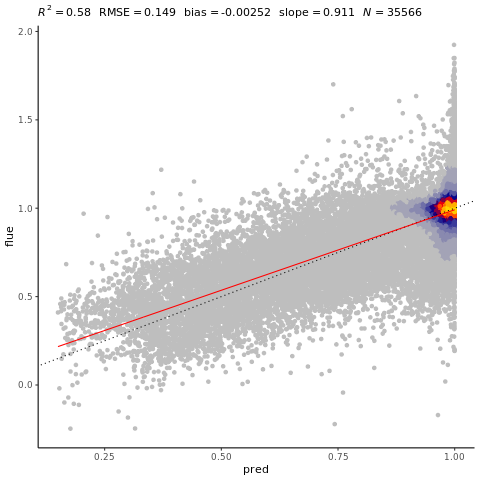

In [61]:
%%R
df_test_inner <- purrr::map_dfr(modl, "df_test")

df_test_inner %>% 
  rbeni::analyse_modobs2("pred", "flue", type = "heat", filnam = str_glue('./results/scatterplot_modl_flue_{model}_{training_method}_{method_fill}_{method_gap}_maxgap_{maxgap}_{n_maxgap}_INNER_{name}_{n_sites}.png'))

# ggsave(str_glue('./results/scatterplot_modl_flue_{model}_{training_method}_INNER_{name}_{missingData}.pdf'))


In [62]:
%%R
# leaving RU-Fyo out
# leave sites that are geographically far away (SD-Dem)
selection <- c("US-SRM") # most data
selection <- c("ENF")
selection <- c("SAV")
selection <- c("GRA")
selection <- c("DBF")
selection <- c("EBF")
selection <- c("DBF", "GRA", "SAV", "ENF") # 
selection <- c("AU-Ade", "AU-ASM", "AU-DaP", "AU-DaS", "AU-Dry", "AU-Stp", "AU-Wom", "DE-Obe",
                 "DE-Tha", "FI-Hyy", "FR-LBr", "IT-Cpz", "IT-Ro1", "IT-SRo", "NL-Loo",
                 "SD-Dem", "US-MMS", "US-SRG", "US-SRM", "US-UMB", "US-UM") 
                    # leave different sites out (NDI): RU-Fyo
selection <- c( "AU-ASM", "AU-DaP", "AU-Dry", "AU-Stp", "AU-Wom", "DE-Obe",
                 "DE-Tha", "FI-Hyy", "FR-LBr", "IT-Cpz", "IT-Ro1", "IT-SRo", 
                 "NL-Loo", "RU-Fyo", "SD-Dem", "US-MMS", "US-SRG", "US-SRM", 
                 "US-UMB", "US-UMd") # sites close to each other excluded 
                                     # (leave US-SRG, AU-DaS, AU-Ade out)
selection <- c("FR-LBr", "IT-Cpz", "IT-Ro1", "IT-SRo") # mediteranian
selection <- c("DE-Obe", "DE-Tha", "FI-Hyy", "FR-LBr", "IT-Cpz", "IT-Ro1", "IT-SRo", "NL-Loo", "RU-Fyo") # europe + russia
selection <- c("DE-Obe", "DE-Tha", "FI-Hyy", "FR-LBr", "IT-Cpz", "IT-Ro1", "IT-SRo", "NL-Loo") # europe
selection <- c("US-MMS", "US-SRG", "US-SRM", "US-UMB", "US-UMd") # US
selection <- c("AU-Ade", "AU-ASM", "AU-DaP", "AU-DaS", "AU-Dry", "AU-Stp", "AU-Wom") # AU
selection <- c("green") # green consists of ebf (wom cpz) and enf 
selection <- c("red") # largest cluster consists of dbf (wom cpz) and enf 
selection <- c("blue")
selection <- c("yellow")
cGR       <- c("AU-Ade", "AU-DaS", "AU-Dry", "FR-LBr", "IT-Cpz", "IT-Ro1","IT-SRo")
cDD       <- c("AU-ASM", "AU-DaP", "AU-Stp", "SD-Dem", "US-SRG", "US-SRM")
cLS       <- c("AU-Wom", "NL-Loo", "RU-Fyo", "US-MMS", "US-UMB", "US-UMd")
cNA       <- c("DE-Obe", "DE-Tha", "FI-Hyy")
ddf_subset <- ddf %>% 
        dplyr::filter(cluster %in% selection) %>% 
        dplyr::filter(cluster %in% selection) %>% 
        # dplyr::filter(site %in% selection) %>% 
        droplevels()